In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
class HMM:
    """
    Simple OOP HMM for discrete observations.

    Attributes
    ----------
    N : int
        Number of hidden states.
    M : int
        Number of observation symbols (observations are integers 0..M-1).
    A : ndarray, shape (N, N)
        State transition probability matrix.
    B : ndarray, shape (N, M)
        Emission probability matrix.
    pi : ndarray, shape (N,)
        Initial state distribution.
    """

    def __init__(self, N, M, init_method="random", seed=None):
        """
        Create an HMM.

        Parameters
        ----------
        N : int
            Number of hidden states.
        M : int
            Number of discrete observation symbols.
        init_method : {"random", "uniform"}
            How to initialize A, B, pi.
        seed : int or None
            Random seed for reproducibility.
        """
        self.N = N
        self.M = M
        self.seed = seed
        if seed is not None:
            np.random.seed(seed)

        if init_method == "random":
            self.A = np.random.rand(N, N)
            self.A = self.A / self.A.sum(axis=1, keepdims=True)
            self.B = np.random.rand(N, M)
            self.B = self.B / self.B.sum(axis=1, keepdims=True)
            self.pi = np.random.rand(N)
            self.pi = self.pi / self.pi.sum()
        elif init_method == "uniform":
            self.A = np.ones((N, N)) / N
            self.B = np.ones((N, M)) / M
            self.pi = np.ones(N) / N
        else:
            raise ValueError("Unknown init_method")

    # Internal helpers
    def _forward_scaled(self, obs):
        T = len(obs)
        N = self.N
        alpha = np.zeros((T, N))
        c = np.zeros(T)  # scaling factors

        alpha[0] = self.pi * self.B[:, obs[0]]
        c[0] = alpha[0].sum()
        if c[0] == 0:
            c[0] = 1e-300
        alpha[0] /= c[0]

        for t in range(1, T):
            alpha[t] = (alpha[t-1] @ self.A) * self.B[:, obs[t]]
            c[t] = alpha[t].sum()
            if c[t] == 0:
                c[t] = 1e-300
            alpha[t] /= c[t]
        return alpha, c

    def _backward_scaled(self, obs, c):
        T = len(obs)
        N = self.N
        beta = np.zeros((T, N))
        beta[T-1] = 1.0 / c[T-1]
        for t in range(T-2, -1, -1):
            beta[t] = (self.A * self.B[:, obs[t+1]]).dot(beta[t+1])
            beta[t] /= c[t]
        return beta


    def _compute_gamma_xi(self, obs, alpha, beta):
        T = len(obs)
        N = self.N
        gamma = np.zeros((T, N))
        xi = np.zeros((T-1, N, N))

        for t in range(T-1):
            numer = alpha[t][:, None] * self.A * (self.B[:, obs[t+1]][None, :]) * beta[t+1][None, :]
            denom = numer.sum()
            if denom == 0:
                denom = 1e-300
            xi[t] = numer / denom
            gamma[t] = xi[t].sum(axis=1)

        gamma[T-1] = alpha[T-1] * beta[T-1]
        gamma = gamma / gamma.sum(axis=1, keepdims=True)
        return gamma, xi

    # Training: Batch Baum-Welch
    def fit(self, sequences, n_iter=100, tol=1e-4):
        """
        Train HMM using Baum–Welch on a list of sequences.

        Parameters
        ----------
        sequences : list of 1D numpy arrays
            Each sequence is an array of ints in 0..M-1.
        n_iter : int
            Max iterations.
        tol : float
            Convergence tolerance on change in total log-likelihood.
        verbose : bool
            Print progress if True.

        Returns
        -------
        loglik_hist : list of float
            Log-likelihood history per iteration.
        """
        N = self.N
        M = self.M
        self.loglik_hist = []

        for it in range(n_iter):
            # accumulators
            A_num = np.zeros((N, N))
            A_den = np.zeros(N)
            B_num = np.zeros((N, M))
            B_den = np.zeros(N)
            pi_acc = np.zeros(N)
            total_loglik = 0.0

            # E-step across all sequences
            for obs in sequences:
                alpha, c = self._forward_scaled(obs)
                beta = self._backward_scaled(obs, c)
                gamma, xi = self._compute_gamma_xi(obs, alpha, beta)

                total_loglik += np.sum(np.log(c + 1e-300))

                pi_acc += gamma[0]
                A_num += xi.sum(axis=0)
                A_den += gamma[:-1].sum(axis=0)

                # emissions
                for k in range(M):
                    mask = (obs == k)
                    if mask.any():
                        B_num[:, k] += gamma[mask].sum(axis=0)
                B_den += gamma.sum(axis=0)

            # M-step: update parameters safely
            self.pi = pi_acc / pi_acc.sum()

            # avoid division by zero
            A_den_safe = np.where(A_den == 0, 1e-300, A_den)
            self.A = A_num / A_den_safe[:, None]
            # numerical regularization: ensure stochastic rows
            self.A = np.where(self.A <= 0, 1e-12, self.A)
            self.A = self.A / self.A.sum(axis=1, keepdims=True)

            B_den_safe = np.where(B_den == 0, 1e-300, B_den)
            self.B = B_num / B_den_safe[:, None]
            self.B = np.where(self.B <= 0, 1e-12, self.B)
            self.B = self.B / self.B.sum(axis=1, keepdims=True)

            self.loglik_hist.append(total_loglik)
            
            if it > 0 and abs(total_loglik - self.loglik_hist[-2]) < tol:
               print(f"Convergence reached at iteration {it+1}.")
               break

            
            if (it + 1) % 10 == 0:
                 print(f"Iteration {it+1}/{n_iter}. Log-Likelihood: {total_loglik:.2f}")

        return None

    # Viterbi decoding
    def viterbi(self, obs):
        """
        Viterbi algorithm to find most likely hidden state path for a single observation sequence.

        Parameters
        ----------
        obs : 1D array-like
            Sequence of observations (ints 0..M-1)

        Returns
        -------
        path : 1D numpy array of ints (0..N-1)
            Most likely sequence of hidden states.
        delta : 2D array (T, N) of log probabilities (optional useful)
        """
        obs = np.asarray(obs, dtype=int)
        T = len(obs)
        N = self.N

        # use log probabilities to avoid underflow
        logA = np.log(self.A + 1e-300)
        logB = np.log(self.B + 1e-300)
        logpi = np.log(self.pi + 1e-300)

        delta = np.zeros((T, N))
        psi = np.zeros((T, N), dtype=int)

        delta[0] = logpi + logB[:, obs[0]]

        for t in range(1, T):
            # compute delta[t, j] = max_i (delta[t-1,i] + logA[i,j]) + logB[j, obs[t]]
            temp = delta[t-1][:, None] + logA  # shape (N,N)
            psi[t] = np.argmax(temp, axis=0)
            delta[t] = np.max(temp, axis=0) + logB[:, obs[t]]

        # backtrack
        path = np.zeros(T, dtype=int)
        path[T-1] = np.argmax(delta[T-1])
        for t in range(T-2, -1, -1):
            path[t] = psi[t+1, path[t+1]]
        return path

    # Likelihood scoring for single sequence
    def score(self, obs):
        """
        Compute log-likelihood of a single observation sequence under current model.
        """
        _, c = self._forward_scaled(obs)
        loglik = np.sum(np.log(c + 1e-300))
        return loglik


    # VISUALIZATION FUNCTIONS

    def plot_matrices(self, obs_labels=None, state_labels=None):
        if state_labels is None:
            state_labels = [f"S{i}" for i in range(self.N)]
        if obs_labels is None:
            obs_labels = [f"O{k}" for k in range(self.M)]

        print("="*50)
        print("TRANSTION MATRIX")
        print("="*50)
        plt.figure(figsize=(10,6))
        sns.heatmap(self.A, annot=True, fmt=".3f", xticklabels=state_labels, yticklabels=state_labels, cmap="Blues")
        plt.title("Transition Matrix A")
        plt.show()
        
        print("="*50)
        print("EMISSION MATRIX")
        print("="*50)
        plt.figure(figsize=(10,6))
        sns.heatmap(self.B, annot=True, fmt=".3f",
                    xticklabels=obs_labels, yticklabels=state_labels, cmap="Greens")
        plt.title("Emission Matrix B")
        plt.show()

    def plot_loglik(self):
        print("="*50)
        print("Log-Likelihood Convergence")
        print("="*50)
        plt.figure(figsize=(10,6))
        plt.plot(self.loglik_hist, marker="o")
        plt.title("Log-Likelihood Convergence")
        plt.xlabel("Iteration")
        plt.ylabel("Log-Likelihood")
        plt.grid(alpha=0.3)
        plt.show()

    def plot_states_vs_observations(self, obs, obs_labels=None, state_labels=None, title="States vs Observations", start_idx=0):
    
        obs = np.asarray(obs, int)
        v_path = self.viterbi(obs)
        T = len(obs)
    
        if obs_labels is None:
            obs_labels = [f"O{i}" for i in range(self.M)]
        if state_labels is None:
            state_labels = [f"S{i}" for i in range(self.N)]
    
        plt.figure(figsize=(14, 4))
    
        # Plot Hidden States (decoded)
        plt.plot(range(start_idx, start_idx + T),
                 v_path,
                 marker='o',
                 linestyle='-',
                 color='blue',
                 label='Decoded Hidden State')
    
        # Plot Observations
        plt.plot(range(start_idx, start_idx + T),
                 obs,
                 marker='x',
                 linestyle='--',
                 color='red',
                 alpha=0.6,
                 label='Observation')
    
        plt.yticks(
            ticks=list(range(self.N)),
            labels=state_labels
        )
    
        # X-ticks every 20 steps
        plt.xticks(range(start_idx, start_idx + T + 20, max(1, T // 5)))
    
        plt.title(title)
        plt.xlabel("Time Step")
        plt.ylabel("State / Observation")
        plt.grid(True, axis='y')
        plt.legend()
        plt.tight_layout()
        plt.show()


    # # Utility: save/load model
    # def save(self, path):
    #     """Save model parameters to a .npz file."""
    #     np.savez(path, A=self.A, B=self.B, pi=self.pi)

    # def load(self, path):
    #     """Load model parameters from a .npz file."""
    #     d = np.load(path)
    #     self.A = d["A"]
    #     self.B = d["B"]
    #     self.pi = d["pi"]
    #     # update N and M in case file differs
    #     self.N = self.A.shape[0]
    #     self.M = self.B.shape[1]


In [3]:
df = pd.read_csv("United_States_weather_data.csv")

In [4]:
df.head()

,Country,Date,Temp_Max,Temp_Min,Temp_Mean,Precipitation_Sum,Windspeed_Max,Windgusts_Max,Sunshine_Duration
0,USA,01-01-2000,16.9,5.5,10.6,0.0,27.0,50.8,31290.47
1,USA,02-01-2000,14.6,5.9,11.9,0.0,26.7,51.5,31333.06
2,USA,03-01-2000,9.0,1.5,5.2,7.1,20.7,42.8,29932.41
3,USA,04-01-2000,1.7,-4.0,-0.9,0.7,24.7,50.0,31429.79
4,USA,05-01-2000,7.1,-2.4,1.6,0.0,28.0,56.9,31483.69


In [5]:
df.isna().sum()

Country              0
Date                 0
Temp_Max             0
Temp_Min             0
Temp_Mean            0
Precipitation_Sum    0
Windspeed_Max        0
Windgusts_Max        0
Sunshine_Duration    0
dtype: int64

In [6]:
# 3 categories
bins = df["Temp_Mean"].quantile([0,0.33,0.66,1]).values
df["obs"] = pd.cut(df["Temp_Mean"], bins=bins, labels=[0,1,2], include_lowest=True).astype(int)
sequence = df["obs"].values

In [7]:
model = HMM(N=3, M=3, seed=42)

model.fit([sequence], n_iter=100)

Iteration 10/100. Log-Likelihood: -6001.03
Iteration 20/100. Log-Likelihood: -5783.31
Iteration 30/100. Log-Likelihood: -5650.83
Iteration 40/100. Log-Likelihood: -3815.01
Iteration 50/100. Log-Likelihood: -3796.72
Convergence reached at iteration 58.


In [8]:
STATES = ["S1", "S2", "S3"]     
OBSERVATIONS = ["O1", "O2", "O3"] 

Pi_learned = model.pi
A_learned = model.A
B_learned = model.B[:, :3] 

print("\n" + "="*60)
print("Learned HMM Parameters after Baum-Welch Training")
print("="*60)

# 1) Initial Probabilities (Pi)
pi_df = pd.DataFrame({
    'State': STATES,
    'Initial Probability': Pi_learned
})

print("\n1. Initial State Probabilities (Pi):")
print(pi_df.to_markdown(index=False))

# 2) Transition Matrix (A)
A_df = pd.DataFrame(
    A_learned,
    index=[f'From {s}' for s in STATES],
    columns=[f'To {s}' for s in STATES]
)

print("\n2. Transition Matrix (A):")
print(A_df.to_markdown())

# 3) Emission Matrix (B)
B_df = pd.DataFrame(
    B_learned,
    index=[f'State {s}' for s in STATES],
    columns=OBSERVATIONS
)

print("\n3. Emission Matrix (B) — 3 Observations:")
print(B_df.to_markdown())

print("\n" + "-"*60)
print("The hidden states now represent the optimized climatic patterns learned from the data!")
print("-"*60)



Learned HMM Parameters after Baum-Welch Training

1. Initial State Probabilities (Pi):
| State   |   Initial Probability |
|:--------|----------------------:|
| S1      |          2.26711e-33  |
| S2      |          1            |
| S3      |          4.25578e-115 |

2. Transition Matrix (A):
|         |       To S1 |     To S2 |       To S3 |
|:--------|------------:|----------:|------------:|
| From S1 | 0.938155    | 0.0618451 | 8.03032e-49 |
| From S2 | 0.072905    | 0.873098  | 0.0539971   |
| From S3 | 4.43698e-36 | 0.0492576 | 0.950742    |

3. Emission Matrix (B) — 3 Observations:
|          |           O1 |        O2 |          O3 |
|:---------|-------------:|----------:|------------:|
| State S1 | 0.911575     | 0.0884245 | 9.71798e-33 |
| State S2 | 0.0102879    | 0.960594  | 0.0291176   |
| State S3 | 1.74552e-111 | 0.0130249 | 0.986975    |

------------------------------------------------------------
The hidden states now represent the optimized climatic patterns learned

Log-Likelihood Convergence


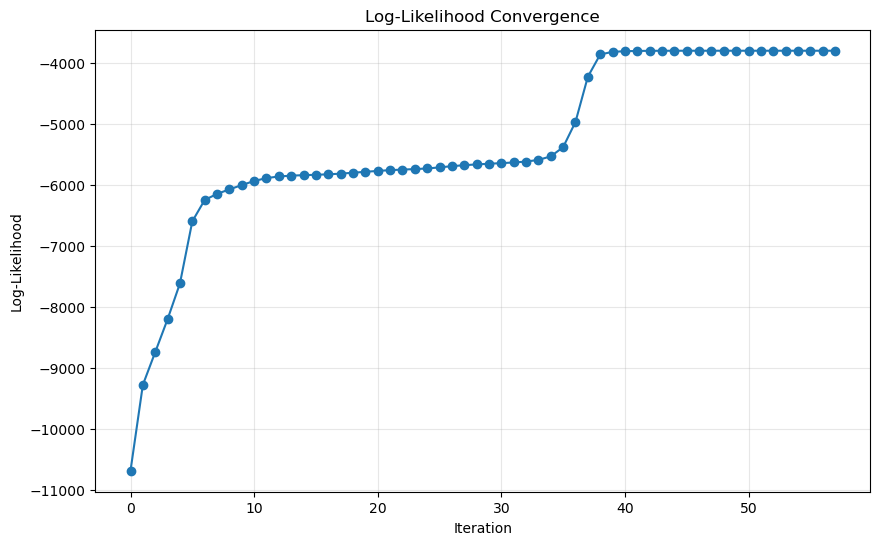

TRANSTION MATRIX


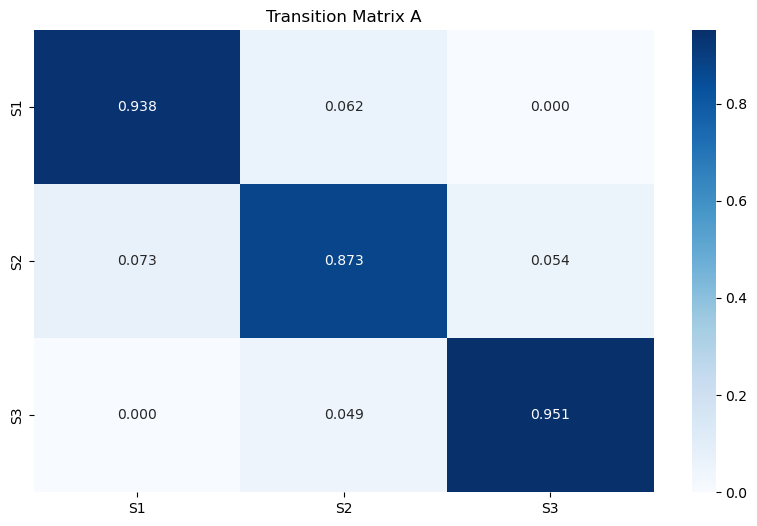

EMISSION MATRIX


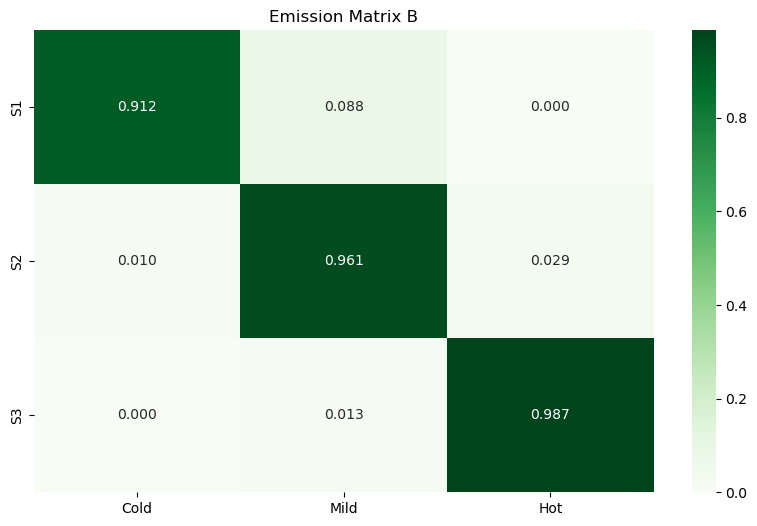

In [9]:
# ---- Visualization ----
model.plot_loglik()
model.plot_matrices(obs_labels=["Cold","Mild","Hot"], state_labels=["S1","S2","S3"])

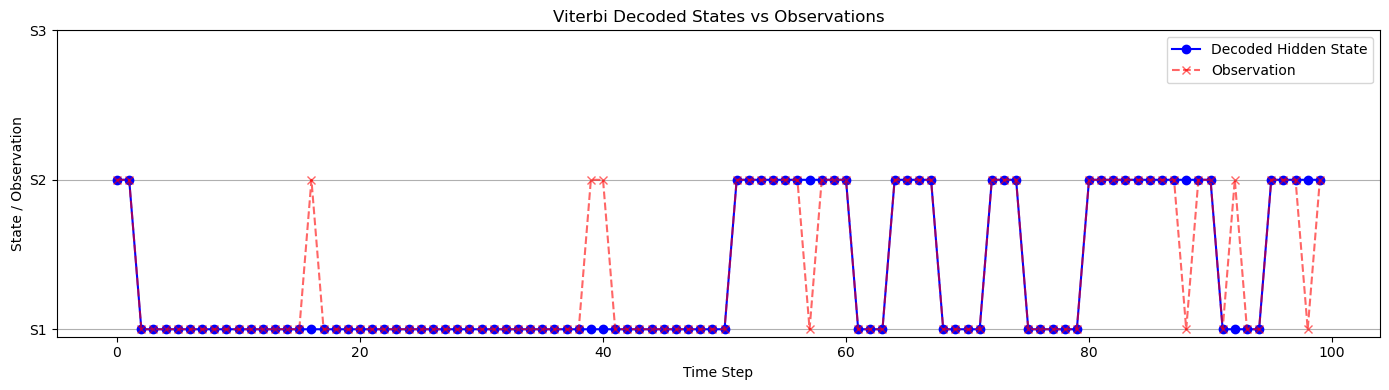

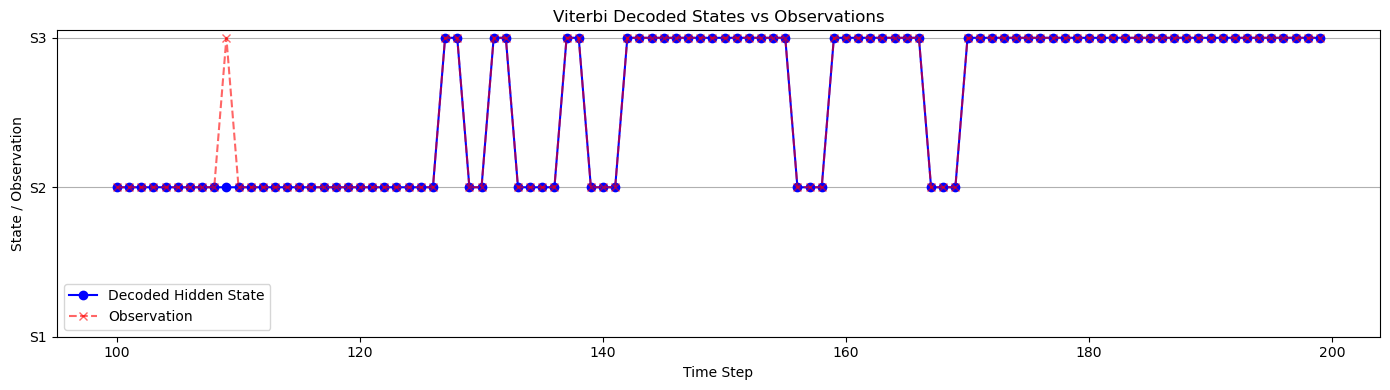

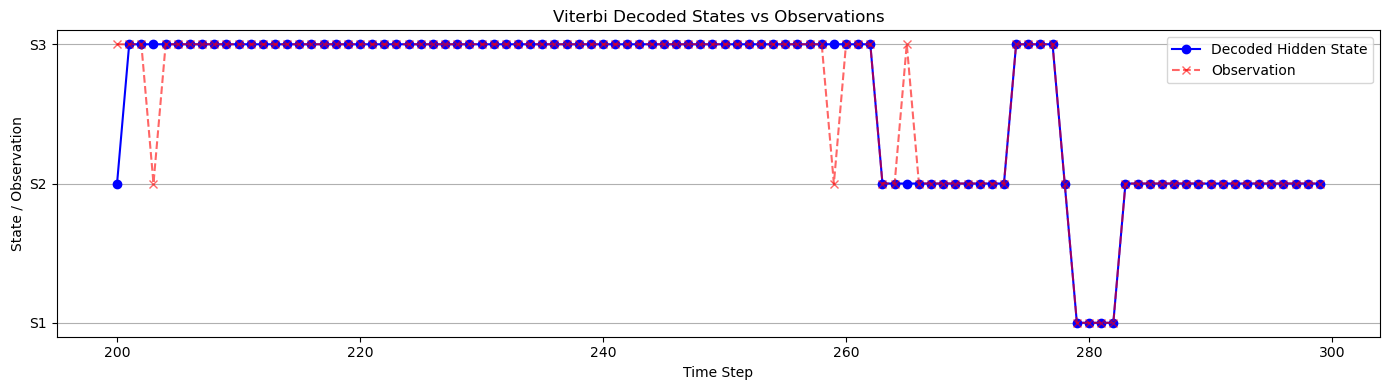

In [10]:
chunk_size = 100
for i in range(0, 3):
    start_idx = i * chunk_size
    model.plot_states_vs_observations(
        sequence[start_idx:start_idx + chunk_size],
        obs_labels=["Cold", "Mild", "Hot"],
        state_labels=["S1", "S2", "S3"],
        title="Viterbi Decoded States vs Observations",
        start_idx=start_idx
    )
